# This notebook will reproduce the plot in Fig. 3 right of 2407.14460

### - Start importing all libraries

In [ ]:
# Import global libs
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

# Import local libs
from fastPTA.angular_decomposition import spherical_harmonics as sph
from fastPTA.angular_decomposition import sqrt_basis as sqb

### - Then set some constants to be used below

In [ ]:
# Confidence level for the Cls
limit_cl = 0.95

# Spherical harmonics order sqrt basis
l_max_sqrt = 3

# Spherical harmonics order linear basis
l_max_lin = 6

# Number of points to be generated
npoints = 10000

# Absolute priors for the coefficients
abs_prior = [0, 50]

# Number of cores to be used for parallel computations
num_cores = cpu_count()

### - Load the NANOgrav constraints in the sqrt basis

In [3]:
limits_NG_sqrt = np.loadtxt("data_paper_2/limits_Cl_powerlaw_sqrt_ng15.dat")

### - Generate the complex gLM in the sqrt basis from the flat prior

In [4]:
# Compute the number of complex coefficients to generate
n_coefficients = sph.get_n_coefficients_complex(l_max_sqrt)

# Generate the gLMs from the priors
LL, MM, _, _, sort_indexes = sph.get_sort_indexes(l_max_sqrt)

# Generate the absolute value for the gLM prior samples
abs_gLM_grid = np.random.uniform(
    low=abs_prior[0],
    high=abs_prior[1],
    size=(npoints, n_coefficients),
)

phi_LM_grid = np.random.uniform(
    low=0.0,
    high=2.0 * np.pi,
    size=(npoints, n_coefficients),
)

# Generate the phases for the gLM prior samples
exp_j_phi_LM_grid = np.exp(1j * phi_LM_grid)

# Assemble to get the gLM
gLM_complex = exp_j_phi_LM_grid * abs_gLM_grid

# For M = 0 the coefficients are real
gLM_complex[:, MM == 0.0] = (
    gLM_complex[:, MM == 0.0].real
    * 2.0
    * (np.heaviside(np.pi - phi_LM_grid[:, MM == 0.0], 0.0) - 0.5)
)

### - Convert from the sqrt to the linear basis

In [5]:
# Compute the linear coefficients from the sqrt coefficients
with Pool(num_cores) as p:
    clm_linear_prior = np.array(
        p.map(
            partial(
                sqb.sqrt_to_lin_conversion,
                l_max_lin=l_max_lin,
                real_basis_input=False,
            ),
            gLM_complex,
            chunksize=int(npoints / num_cores),
        )
    )

/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### - Compute the Cls in the linear basis

In [6]:
# Normalize such that c00 = sqrt(4.*pi), see NG15 paper
clm_linear_prior = (np.sqrt(4.0 * np.pi) / clm_linear_prior[:, 0])[
    :, None
] * clm_linear_prior

# Compute the Cls from the linear coefficients
CL_linear_prior = sph.get_CL_from_real_clm(clm_linear_prior.T)

### - Plot the results

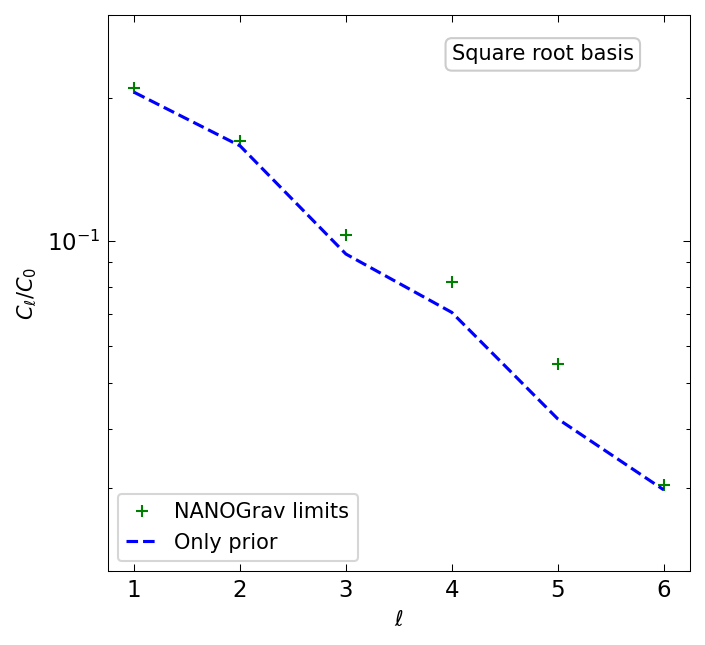

In [7]:
fig = plt.figure(figsize=(0.4 * 12.0, 0.4 * 11.0), dpi=150, edgecolor="white")

ax = fig.add_subplot(1, 1, 1)
ax.tick_params(
    axis="both", which="both", labelsize=11, direction="in", width=0.5
)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(0.5)

ax.semilogy(
    *limits_NG_sqrt.T,
    label=r"NANOGrav limits",
    color="green",
    marker="+",
    lw=0,
)

ax.semilogy(
    np.arange(1, l_max_lin + 1),
    np.quantile(
        CL_linear_prior[1:] / CL_linear_prior[0, :],
        limit_cl,
        axis=-1,
    ),
    "blue",
    ls="--",
    label=r"Only prior",
)

# ax.set_title(r"NANOGrav positions")
plt.legend(loc="lower left", fontsize=10, handlelength=1.5)

ax.text(
    4,
    2.6e-1,
    r"Square root basis",
    horizontalalignment="left",
    fontsize=10,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round",
        facecolor="white",
        alpha=1,
        linewidth=1,
        edgecolor="0.8",
    ),
    linespacing=1.4,
)

# set x axis label
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$C_\ell / C_0$")
plt.ylim(2e-2, 3e-1)

plt.tight_layout()
plt.savefig("plots/sqrt_prior_limits.pdf")
plt.show()